In [1]:
import random
import matplotlib.pyplot as plt
import cv2

from detectron2.data import DatasetCatalog, MetadataCatalog, get_detection_dataset_dicts, print_instances_class_histogram
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.utils.logger import setup_logger

from data_utils import read_split_file, register_dataset

setup_logger()
%matplotlib inline

### Check Mixed

In [2]:
mixed_sets = read_split_file("data/panels/mixed/split.txt")

# Register mixed datasets
for spl, im_paths in zip(["train", "val", "test"], mixed_sets):
    DatasetCatalog.register(
        f"mixed_{spl}", lambda im_paths=im_paths: register_dataset(im_paths)
    )
    MetadataCatalog.get(f"mixed_{spl}").set(
        thing_classes=["label", "button"],
        thing_colors=[(0, 255, 0), (0, 0, 255)],
    )

In [4]:
trainset = get_detection_dataset_dicts("mixed_train", filter_empty=False)
valset = get_detection_dataset_dicts("mixed_val", filter_empty=False)
testset = get_detection_dataset_dicts("mixed_test", filter_empty=False)
dataset = trainset + valset + testset
print(len(dataset))
print(len(trainset))
print(len(valset))
print(len(testset))

registering mixed dataset: 100%|██████████| 22/22 [00:00<00:00, 26.41it/s]

108
76
10
22


### Check the UT-West-Campus Dataset

In [6]:
ut_west_campus_sets = read_split_file("data/panels/ut_west_campus/split.txt")

# Register ut_west_campus datasets
for spl, im_paths in zip(["train", "val", "test"], ut_west_campus_sets):
    DatasetCatalog.register(
        f"ut_west_campus_{spl}", lambda im_paths=im_paths: register_dataset(im_paths)
    )
    MetadataCatalog.get(f"ut_west_campus_{spl}").set(
        thing_classes=["label", "button"],
        thing_colors=[(0, 255, 0), (0, 0, 255)],
    )

In [7]:
trainset = get_detection_dataset_dicts("ut_west_campus_train", filter_empty=False)
valset = get_detection_dataset_dicts("ut_west_campus_val", filter_empty=False)
testset = get_detection_dataset_dicts("ut_west_campus_test", filter_empty=False)
dataset = trainset + valset + testset
print(len(dataset))
print(len(trainset))
print(len(valset))
print(len(testset))

registering ut_west_campus dataset: 100%|██████████| 192/192 [00:41<00:00,  4.58it/s]

[03/02 00:04:04 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   label    | 2310         |   button   | 2310         |
|            |              |            |              |
|   total    | 4620         |            |              |



registering ut_west_campus dataset: 100%|██████████| 12/12 [00:03<00:00,  3.84it/s]

[03/02 00:04:07 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   label    | 174          |   button   | 174          |
|            |              |            |              |
|   total    | 348          |            |              |



registering ut_west_campus dataset: 100%|██████████| 88/88 [00:18<00:00,  4.67it/s]

[03/02 00:04:26 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   label    | 982          |   button   | 982          |
|            |              |            |              |
|   total    | 1964         |            |              |
292
192
12
88


Use the function below to generate the tables if its not popping up for you

In [ ]:
print_instances_class_histogram(dataset, ["label", "button"])

In [ ]:
print_instances_class_histogram(testset, ["label", "button"])

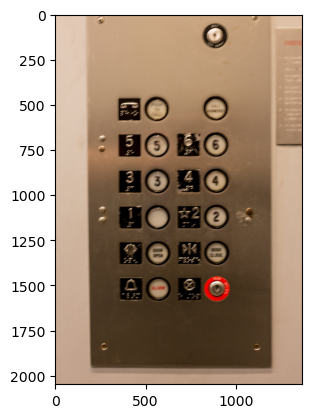

In [18]:
sampled_dicts = random.sample(dataset, len(trainset))

d = sampled_dicts[0]
og_img = cv2.imread(d["file_name"])
plt.imshow(og_img[:, :, ::-1])

In [ ]:
def get_optimal_font_scale(text, width):

    for scale in reversed(range(0, 60, 1)):
        textSize = cv2.getTextSize(text, fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=scale/10, thickness=1)
        new_width = textSize[0][0]
        if (new_width <= width):
            return scale/10
    return 1

In [23]:
import json
import os

from data_utils import generate_bbox, generate_gt_mask_coords

symbol_map = {
    "<|>": "open",
    ">|<": "close",
    "^": "alarm",
    "&": "call",
    "#": "stop",
    "><": "rear door close",
    "<>": "rear door open",
    "F|>": "front door open",
    "F|<": "front door close",
    "R|>": "rear door open",
    "R|<": "rear door close",
}

annos = json.load(open("data/panels/mixed/annotations.json"))
for d in sampled_dicts:
    if "mixed_16.jpg" not in d["file_name"]:
        continue
    img = cv2.imread(d["file_name"])
    height, width = img.shape[:2]
    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=MetadataCatalog.get("mixed_train"),
        scale=1,
        instance_mode=ColorMode.SEGMENTATION,
    )
    out = visualizer.draw_dataset_dict(d)
    img_dict = annos[os.path.basename(d["file_name"])]
    for r in img_dict["regions"]:
        pair = r["region_attributes"].get("pair")
        if pair is None or pair == "":
            continue

        pair = pair.rstrip().lower()
        if r["region_attributes"]["category_id"] == "button" and (
            r["region_attributes"]["pair"] is not None
            or r["region_attributes"]["pair"] != ""
        ):
            bbox = generate_bbox(
                *generate_gt_mask_coords(r, height, width), height, width
            )
            visualizer.draw_text(
                pair if pair not in symbol_map else symbol_map[pair],
                (int(bbox[0] + bbox[2]) / 2, int((bbox[1] + bbox[3]) / 2)),
                color="r",
                horizontal_alignment="center",
            )

            # cv2.putText(
            #     out,
            #     text=pair if pair not in symbol_map else symbol_map[pair],
            #     org=(int(bbox[0]) + 5, int((bbox[1] + bbox[3]) / 2)),
            #     fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            #     fontScale=3,
            #     color=(255, 0, 0),
            #     thickness=5,
            # )

    out = out.get_image()
    cv2.imwrite(f"big_graphic/{os.path.basename(d['file_name'])}", out[:, :, ::-1])
    # plt.imshow(out.get_image())
    # plt.axis("off")
    # plt.show()
